In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from PIL import Image
import os 
import json
import tensorflow as tf
import numpy as np 

In [2]:
from tensorflow.keras.datasets import mnist
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:    
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:        
        print(e)

Loading a Trained Model

In [5]:
model = torch.load('./model/MNIST.pth')# Loading the ResNet-50 Version Trained on the MNIST Dataset
model.eval()
print(model)#Printing the Model Architecture

GraphModule(
  (initializers): Module()
  (Reshape_0): OnnxReshape()
  (Conv_0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (Relu_0): ReLU()
  (Pad_0): OnnxPadDynamic()
  (MaxPool_0): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Conv_1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Conv_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (Relu_1): ReLU()
  (Conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_2): ReLU()
  (Conv_4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Add_0): OnnxBinaryMathOperation()
  (Relu_3): ReLU()
  (Conv_5): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (Relu_4): ReLU()
  (Conv_6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_5): ReLU()
  (Conv_7): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Add_1): OnnxBinaryMathOperation()
  (Relu_6): ReLU()
  (Conv_8): Conv2d(256, 64, kernel_size=(1, 

Loading the Dataset

In [6]:
CLASSES = json.load(open('./model/mnist_class_index.json'))
#Loading the Dataset for Training (Class JSON File)
idx2class = [CLASSES[str(i)] for i in range(10)]
print(idx2class)
#Setting Class IDs

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Loading the Image

In [7]:
def fgsm_attack(image, epsilon, gradient):
    # Computing the Sign of the Gradient Elements
    sign_gradient = gradient.sign()
    # Adjusting Each Pixel Value of the Image by Epsilon in the Sign Gradient Direction
    perturbed_image = image + epsilon * sign_gradient
    # Clipping Values Outside the [0, 1] Range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

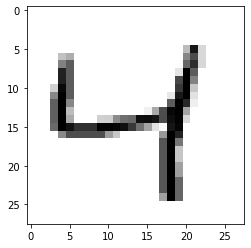

In [8]:
plt.imshow(train_images[2],cmap=plt.cm.binary)

In [9]:
img_transforms = transforms.Compose([ 
    #transforms.Resize((28, 28), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(train_images[2])
img_tensor = img_tensor.unsqueeze(0)

print("Image Tensor Shape:", img_tensor.size())

img_tensor.requires_grad_(True)

# Passing the Image through the Model
output = model(img_tensor)

# Calculating the Error Value
loss = F.nll_loss(output, torch.tensor([train_labels[2]])) 

# Calculating the Gradient
model.zero_grad()
loss.backward()
#Storing the Derivatives and Extracting the Gradient Values

# Extracting the Gradient of the Image
gradient = img_tensor.grad.data

# Generating Adversarial Examples Using the FGSM Attack
epsilon = 0.3
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
#save_image(perturbed_data, path2+i)
#print('%s is successfully added' %(path2+i))

img_reshaped = perturbed_data.squeeze().detach().numpy()
img_pil = Image.fromarray((img_reshaped * 255).astype('uint8'), mode='L')
# img_name = f"image_{i}.png"
# img_pil.save(path2+img_name)
# print('%s is successfully added' %(i))  

Image Tensor Shape: torch.Size([1, 1, 28, 28])


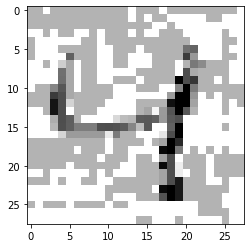

In [10]:
plt.imshow(img_pil,cmap=plt.cm.binary)
plt.show()

In [11]:
ori_output = model(img_tensor)
ori_prediction = ori_output.max(1,keepdim=True)[1]
#Highest Probability Prediction Class

prediction_idx = ori_prediction.item()

prediction_name = idx2class[prediction_idx]

output = model(perturbed_data)
prediction = output.max(1,keepdim=True)[1]
#Highest Probability Prediction Class

prediction_idx = prediction.item()

print("Predicted Label Number:", prediction_idx)
print("Actual Label:", prediction_name)

Predicted Label Number: 2
Actual Label: 4
